# Fully-supervised Semantic Segmentation

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import os
from pathlib import Path
import re

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [6]:
from config import IMAGE_DATA_DIR, GT_DIR, IMAGE_DATA_TILES_DIR, GT_TILES_DIR, GT_ADJ_TILES_DIR, TILES_DIR, LABELS, RED, BLACK, N1, N2, N_validation

In [7]:
gt_tiles_dir = GT_ADJ_TILES_DIR

In [8]:
BASE_DIR = Path('').absolute().parent; BASE_DIR

PosixPath('/home/jupyter/weakly-supervised-semseg')

In [9]:
image_tiles_fnames = os.listdir(BASE_DIR / IMAGE_DATA_TILES_DIR)

In [10]:
fname = image_tiles_fnames[0]

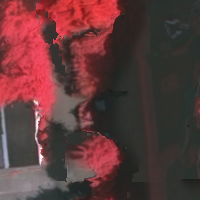

In [11]:
open_image( BASE_DIR / IMAGE_DATA_TILES_DIR / fname)

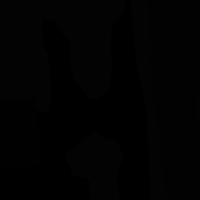

In [12]:
open_image(BASE_DIR / gt_tiles_dir / fname)

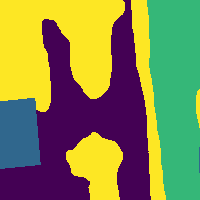

In [177]:
mask = open_mask(BASE_DIR / gt_tiles_dir / fname)
# mask.show(figsize=(5,5), alpha=1)
mask

In [178]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([200, 200]),
 tensor([[[3, 3, 3,  ..., 2, 2, 2],
          [3, 3, 3,  ..., 2, 2, 2],
          [3, 3, 3,  ..., 2, 2, 2],
          ...,
          [0, 0, 0,  ..., 2, 2, 2],
          [0, 0, 0,  ..., 2, 2, 2],
          [0, 0, 0,  ..., 2, 2, 2]]]))

### Load data

In [14]:
def get_y_fn(x):
    return BASE_DIR / gt_tiles_dir / x.name

In [174]:
free = gpu_mem_get_free_no_cache(); free

14699

In [198]:
base_path = "top_mosaic_09cm_area"
prog = re.compile(fr"{base_path}(?P<area_id>\d+)_tile(?P<tile_id>\d+).tif")

def is_in_set(x, N):
    fname = x.name  # e.g.: top_mosaic_09cm_area30_tile120.tif'

    match_result = prog.search(fname)
    area_id = match_result.group('area_id')
    tile_id = match_result.group('tile_id')
    image_fname = f"{base_path}{area_id}.tif"  # e.g.: top_mosaic_09cm_area30.tif'
    return image_fname in N

is_in_set_n1 = partial(is_in_set, N=N1)
is_in_set_n2 = partial(is_in_set, N=N2)
is_in_set_nvalidation = partial(is_in_set, N=N_validation)
is_in_set_n1_or_nvalidation = partial(is_in_set, N=N1+N_validation)

codes = LABELS+[RED, BLACK]

src_size = np.array(mask.shape[1:])
src_size,mask.data
size = src_size

item_list = (SegmentationItemList.from_folder(BASE_DIR / IMAGE_DATA_TILES_DIR)  #returns SegmentationItemList
             .filter_by_func(is_in_set_n1_or_nvalidation)  #returns SegmentationItemList
             .split_by_valid_func(is_in_set_nvalidation)  #returns ItemLists(SegmentationItemList, SegmentationItemList)
             .label_from_func(get_y_fn, classes=codes)  #returns LabelLists(LabelList, SegmentationItemList)
             .transform(get_transforms(), size=size, tfm_y=True)
            )

In [199]:
get_transforms()

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do

In [200]:
item_list

LabelLists;

Train: LabelList (390 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: /home/jupyter/weakly-supervised-semseg/data/ISPRS_semantic_labeling_Vaihingen/top_tiles;

Valid: LabelList (935 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: /home/jupyter/weakly-supervised-semseg/data/ISPRS_semantic_labeling_Vaihingen/top_tiles;

Test: None

In [201]:
# TODO transform(get_transforms(), size=size, tfm_y=True)
# TODO make faster if I convert the labels from 3channels to 6 different integers
bs = 8
data = item_list.databunch(bs=bs).normalize(imagenet_stats)

In [202]:
data.classes

[(255, 255, 255),
 (0, 0, 255),
 (0, 255, 255),
 (0, 255, 0),
 (255, 255, 0),
 (255, 0, 0),
 (0, 0, 0)]

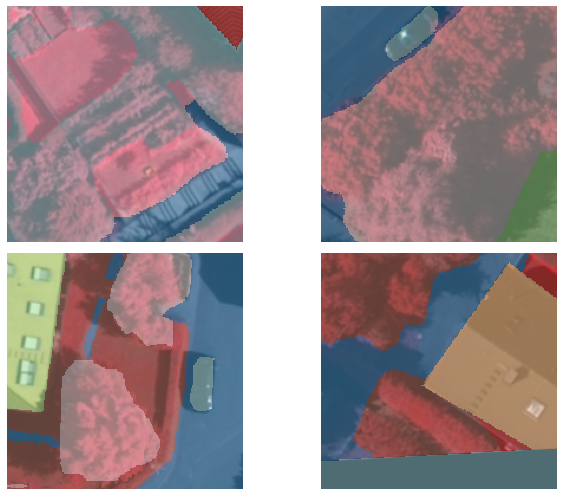

In [203]:
data.show_batch(2, figsize=(10,7))

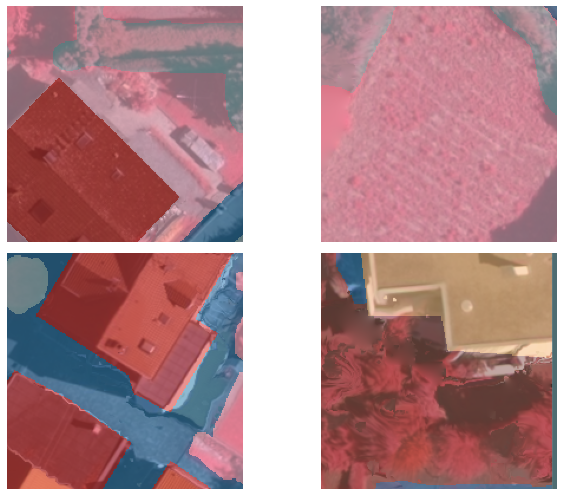

In [204]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [205]:
item_list

# all tiles: 4497
# 935 / 4497 = 20%
# 390 / 4497 = 8.6%

# This seems to be the desired split

LabelLists;

Train: LabelList (390 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: /home/jupyter/weakly-supervised-semseg/data/ISPRS_semantic_labeling_Vaihingen/top_tiles;

Valid: LabelList (935 items)
x: SegmentationItemList
Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200),Image (3, 200, 200)
y: SegmentationLabelList
ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200),ImageSegment (1, 200, 200)
Path: /home/jupyter/weakly-supervised-semseg/data/ISPRS_semantic_labeling_Vaihingen/top_tiles;

Test: None

## Model

Train and compare semantic segmentation networks, using the following data: Task (i) N1 pixel level labels

In [206]:
name2id = {v:k for k,v in enumerate(codes)}  # {WHITE:0, BLUE:1}
void_codes_red = name2id[RED]
void_codes_black = name2id[BLACK]

def acc_satellite(input, target):
    target = target.squeeze(1)
    mask = target != void_codes_red
    mask = target != void_codes_black
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [207]:
wd=1e-2

In [208]:
learn = unet_learner(data, models.resnet18, metrics=acc_satellite, wd=wd)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fda1cf58560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


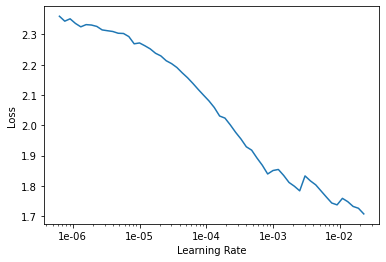

In [192]:
lr_find(learn)
learn.recorder.plot()

In [195]:
lr=3e-4

In [209]:
learn.fit_one_cycle(30, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_satellite,time
0,1.567593,1.335647,0.495647,00:14
1,1.229984,0.989863,0.640724,00:14
2,1.012908,0.956812,0.646391,00:14
3,0.886580,0.773226,0.715356,00:14
4,0.797499,0.741862,0.719523,00:14
5,0.736301,0.711997,0.727036,00:14
6,0.682698,0.729584,0.720207,00:14
7,0.701836,0.698563,0.742823,00:14
8,0.646037,0.633538,0.761516,00:14
9,0.630194,0.744057,0.710219,00:14


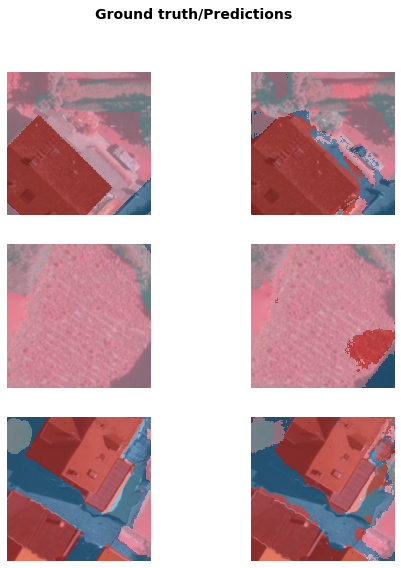

In [210]:
learn.show_results(rows=3, figsize=(8,9))